In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import mxnet as mx
from mxnet import image
from mxnet.gluon.data.vision import transforms
from gluoncv.data.transforms.presets.segmentation import test_transform
import gluoncv
from gluoncv.utils.viz import get_color_pallete
import matplotlib.image as mpimg


In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

sample_submission = pd.read_csv('../input/mds-misis-dl-person-segmentation/sample-submission.csv')
image_paths_list = '/kaggle/input/coco2017/val2017/' + sample_submission.ImageId
image_paths_list

0       /kaggle/input/coco2017/val2017/val2017/0000005...
1       /kaggle/input/coco2017/val2017/val2017/0000004...
2       /kaggle/input/coco2017/val2017/val2017/0000003...
3       /kaggle/input/coco2017/val2017/val2017/0000003...
4       /kaggle/input/coco2017/val2017/val2017/0000003...
                              ...                        
2688    /kaggle/input/coco2017/val2017/val2017/0000002...
2689    /kaggle/input/coco2017/val2017/val2017/0000000...
2690    /kaggle/input/coco2017/val2017/val2017/0000004...
2691    /kaggle/input/coco2017/val2017/val2017/0000000...
2692    /kaggle/input/coco2017/val2017/val2017/0000004...
Name: ImageId, Length: 2693, dtype: object

In [3]:
import mxnet as mx
from mxnet import image
from mxnet.gluon.data.vision import transforms
from gluoncv.data.transforms.presets.segmentation import test_transform
import gluoncv
from gluoncv.utils.viz import get_color_pallete
import matplotlib.image as mpimg

ctx = mx.gpu(1)

In [4]:
ctx = mx.gpu(0)
models = {
    'fcn_resnet101_coco': {'prediction_codes': 'pascal_voc'},
    'psp_resnet101_coco': {'prediction_codes': 'pascal_voc'},
    'deeplab_resnet101_coco': {'prediction_codes': 'pascal_voc'},
}

for model_name, model_info in models.items():
    model_info['model'] = gluoncv.model_zoo.get_model(model_name, pretrained=True, ctx=ctx,
                                                     norm_layer= mx.gluon.contrib.nn.SyncBatchNorm
                                                )

person_indices = {
    'pascal_voc': 15
}

/opt/conda/lib/python3.7/site-packages/mxnet/gluon/contrib/nn/basic_layers.py:240: UserWarning: Caution using SyncBatchNorm: if not using all the GPUs, please mannually set num_devices
  UserWarning)


100121KB [00:05, 17352.01KB/s]                           


100%|██████████| 197325/197325 [00:10<00:00, 19529.76KB/s]


self.crop_size 480


100%|██████████| 266385/266385 [00:13<00:00, 19967.24KB/s]


100%|██████████| 221704/221704 [00:10<00:00, 20314.14KB/s]


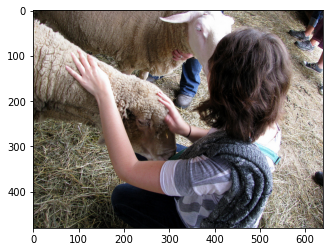

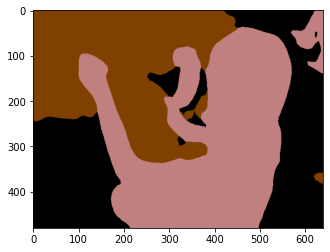

In [5]:
def get_all_predictions(img_orig, model_name):
    img = mx.nd.array(img_orig)
    img = test_transform(img, ctx)
    model_info = models[model_name]
    output = model_info['model'].predict(img)
    predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()
    predict = get_color_pallete(predict, model_info['prediction_codes'])
    return predict

image = np.array(Image.open(image_paths_list[1]))
plt.imshow(image)
plt.show()

predict = get_all_predictions(image, 'deeplab_resnet101_coco')
plt.imshow(predict)
plt.show()

814


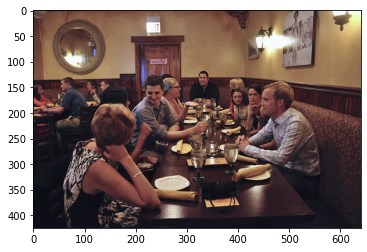

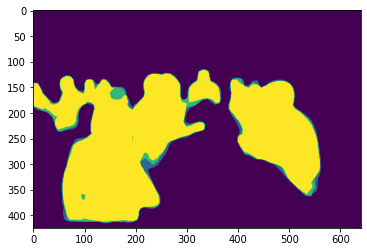

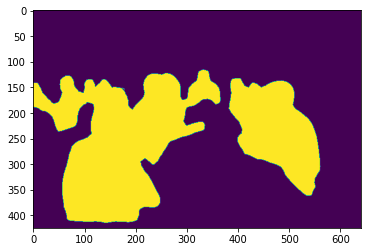

In [6]:
from random import randrange
def get_mask(img_orig, threshold = None):
    img = mx.nd.array(img_orig)
    img = test_transform(img, ctx)
    masks = []
    for model_name, model_info in models.items():
        model = model_info['model']
        person_idx = person_indices[model_info['prediction_codes']]
        output = model.predict(img)
        predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()
        predict = (predict == person_idx).astype(int)
        masks.append(predict)
    mask = np.mean(np.array(masks), axis = 0)
    if threshold is not None:
        mask = np.where(mask > threshold, 1, 0)
    return mask

random_image = randrange(1, 1000)
print(random_image)

image = np.array(Image.open(image_paths_list[random_image]))
plt.imshow(image)
plt.show()

mask = get_mask(image)
plt.imshow(mask)
plt.show()

mask = get_mask(image, threshold = 0.5)
plt.imshow(mask)
plt.show()


In [7]:
predictions = []
from tqdm.notebook import tqdm
for path in tqdm(image_paths_list):
    image = np.array(Image.open(path).convert('RGB'))
    image = image * (255.0/image.max())
    predictions.append(get_mask(image, threshold = 0.5))

  0%|          | 0/2693 [00:00<?, ?it/s]

In [8]:
def mask_to_rle(mask):
    mask_flat = mask.flatten('F')
    flag = 0
    rle_list = list()
    for i in range(mask_flat.shape[0]):
        if flag == 0:
            if mask_flat[i] == 1:
                flag = 1
                starts = i+1
                rle_list.append(starts)
        else:
            if mask_flat[i] == 0:
                flag = 0
                ends = i
                rle_list.append(ends-starts+1)
    if flag == 1:
        ends = mask_flat.shape[0]
        rle_list.append(ends-starts+1)
    #sanity check
    if len(rle_list) % 2 != 0:
        print('NG')
    if len(rle_list) == 0:
        rle = np.nan
    else:
        rle = ' '.join(map(str,rle_list))
    return rle

In [9]:
predictions_encoded = [mask_to_rle(mask) for mask in tqdm(predictions)]
sample_submission['EncodedPixels'] = predictions_encoded
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()

  0%|          | 0/2693 [00:00<?, ?it/s]

,ImageId,EncodedPixels
0,val2017/000000532481.jpg,112231 1 112657 2 113083 2 113509 3 113934 4 1...
1,val2017/000000458755.jpg,46701 8 47176 14 47651 21 48126 28 48590 46 49...
2,val2017/000000385029.jpg,399 82 879 82 1359 82 1839 82 2319 82 2798 83 ...
3,val2017/000000311303.jpg,25202 1 25627 4 26053 7 26479 9 26905 11 27331...
4,val2017/000000393226.jpg,44966 3 45443 11 45919 16 46396 19 46874 21 47...
